# Tutorial 6: trajectory optimisation

In this tutorial we are going to optimise the trajectory of a cannon firing a ball at a target.
We are somehow limited by the capabilities of the python default solvers here, but this will be the opportunity to remind ourselves that non-linear programs are not things that are easy to solve.

The problem is thus the following:
We need to optimise the initial velocity of a canonball such that it hits the ground at a specified target location.
This is the illustration that we have seen a few minutes ago in class, which I borrowed from Matthew Kelly (his whole video is interesting if you want further details on trajectory optimisation):
http://www.matthewpeterkelly.com/tutorials/trajectoryOptimization/canon.html

In this problem, our state is described by 4 variables, $\mathbf{z} = [x,y,dx,dy]$ which describe the 2D positions and velocities of the ball. 

The decision variables are the initial velocity parameters $dx_0, dy_0$ (we always start from $x_0 = 0, y_0 = 0$) as well as the total duration of the trajectory $t$. Therefore our problem has only 3 decision variables.

We will first model the simulation of the cannon being fired, and then write our optimisation problem


## Writing the dynamics

We can first compute the derivative of our state $\mathbf{z}(t)$
As usual let's import a bunch of useful libraries first and define a few variables:

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi, cos, sin

g = 1 #gravity of 1 for simplifying the problem
m = 1 # mass of the object in kilos (assumed to be a point mass)
c = 0.2 # quadratic air drag

In [23]:
def canondynamics(t,z):
    '''Computes the derivative of the state z'''
    dx = z[2] #z = [x,y,dx,dy]
    dy = z[3]
    v = np.linalg.norm([dx,dy])
    #First-order form (derivative of position states is velocity states)
    dz = np.zeros(z.shape)
    dz[:2] = z[2:]; #dz = [dx,dy,ddx,ddz], so dx, dy is a simple copy
    fx = -c*dx*v #applying quadratic drag
    fy = -c*dy*v - m*g #on y axis we further apply velocity
    dz[2] = fx
    dz[3] = fy
    return dz 

Our system has the form $\dot{z} = f(z)$, which relates to an ODE. Rather than working out the equations by ourselves, we can use a scipy function that will perform the integration for us, called solve_ivp. Take a look at the doc to understand its use.
In the following function we are simply going to integrate the dynamics for a while given an initial state. We will then fit a polynomial on the points above the ground to obtain the trajectory. 

In [30]:
from scipy.integrate import solve_ivp

def simulate(z0):
    '''Simulates the trajectory of the canonball until t = 100 (ignoring collisions)'''
    res = solve_ivp(canondynamics, [0,100], z0, dense_output=False)
    y = res["y"]
    trajx, trajy = y[0,:], y[1,:]    
    # getting the last index before the ground is hit
    idx = -1
    for i, y in enumerate(trajy):
        if y < 0:
            idx = i+1
            break
    coefficients = np.polyfit(trajx[:idx], trajy[:idx], 10) #fit a degree 10 polynomial on this
    poly_func = np.poly1d(coefficients)
    return poly_func

def plot_trajectory(z0, target):    
    '''Given a target and an initial state condition plots the trajectory that results from the integration'''
    poly_func = simulate(z0)
    x = np.linspace(0, 100,1000) 
    x_up = [el for el in x if poly_func(el) >= -0.01 and el < target[0]+1.]
    plt.plot(x_up, poly_func(x_up), label='trajectory for z0 =' + str(z0))  
    plt.scatter(target[0],target[1])
    plt.plot([x[0],max(x_up[-1],target[0])],[0,0], label='y = f(x)')  #ground
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()
    

Ideally, we should rather work out the time the trajectory intersects with the ground. You can try to solve this as an exercise.

Let's try to plot a trajectory starting at angle 45 degrees with a magnitude of 6 meters per second:


/tmp/ipykernel_210671/524005165.py:19: RankWarning: Polyfit may be poorly conditioned
  poly_func = simulate(z0)


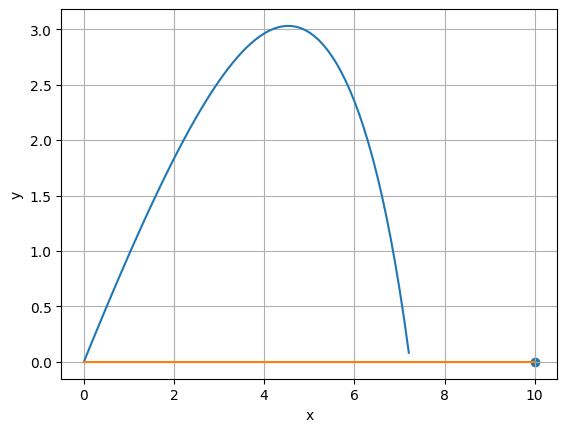

In [31]:
th0 = 45*(pi/180); #shooting angle
v0 = 6
dx0 = v0*cos(th0);
dy0 = v0*sin(th0);

z0 = np.array([0,0,dx0,dy0])

plot_trajectory(z0, target=[10.,0.])

## Optimisation
We are now going to solve our problem using numerical optimisation. 
We only have one control, the initial velocity, as well as the total time for the trajectory. That gives us 3 decision variables.

Let us first solve a feasibility problem: Given a target, the following function generates a constraint / cost that unrolls the trajectory and returns the distance between the target and the actual location reached for a given initial condition. We decide that our trajectory is discretised into N collocation points

In [48]:
N = 100

def targetconstraint(target):
    def constraint(x): #x = [dx0, dy0, t]
        z0 = [0,0,x[0],x[1]] #retrieve initial state
        #find end positions 
        t = x[-1] #retrieve time
        dt = t/N
        zprev = np.array(z0)
        fprev = np.zeros(zprev.shape)
        for i in range(N):
            tcurrent = i*dt
            fcurrent=canondynamics(tcurrent,zprev)
            z = zprev + 0.5*dt * (fprev + fcurrent) #trapezoidal integration
            fprev = fcurrent
            zprev = z
        return np.linalg.norm(z[:2]-target)
    return constraint


Now let's solve this with BFGS:
You'll see a couple of warnings popping up

In [49]:
from scipy.optimize import fmin_bfgs

target = [9.5, 0] 
xopt = fmin_bfgs(targetconstraint(target), z0, callback=None)

print ("the optimal initial velocity is: ", xopt[:2])
print ("the trajectory duration obtained is: ", xopt[-1])


         Current function value: 0.000002
         Iterations: 23
         Function evaluations: 302
         Gradient evaluations: 58
the optimal initial velocity is:  [7.86068884 4.49140438]
the trajectory duration obtained is:  4.310237978908701


Let us simulate this trajectory to see if we are where we want

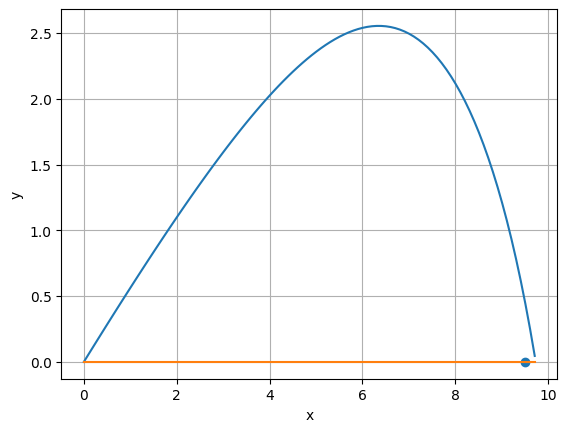

In [50]:
zopt = [0.,0.,xopt[0], xopt[1]]
plot_trajectory(zopt, target)

You should obtain something that is not so far. Increasing the number of knots to 200 should get you closer to the target

         Current function value: 0.000001
         Iterations: 26
         Function evaluations: 410
         Gradient evaluations: 80
the optimal initial velocity is:  [7.69844618 4.36904215]
the trajectory duration obtained is:  4.286939807106811


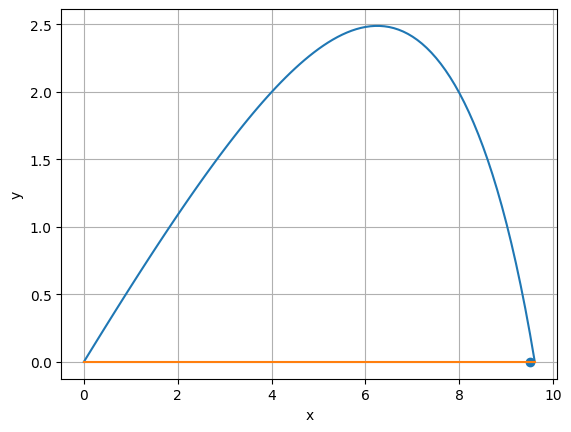

In [54]:
N=200
xopt = fmin_bfgs(targetconstraint(target), z0, callback=None)
print ("the optimal initial velocity is: ", xopt[:2])
print ("the trajectory duration obtained is: ", xopt[-1])
zopt = [0.,0.,xopt[0], xopt[1]]
plot_trajectory(zopt, target)

If you play around with the parameters, you will see that in many instances the solver will not converge unless a relevant initial guess is provided.

## Exercises (optional):
Write the code to display the discretised trajectory that you integrate linearly in your optimisation problem, and compare it with the result of the simulation.